## Comparing baseline model fits

In [1]:
import numpy as np
import scipy.stats as stats
import nibabel.freesurfer.mghformat as mgh
import h5py

import sys

sys.path.append("..")

from paths import *
from constants import *

sys.path.append(CODE_PATH)

from utils.general_utils import make_iterable

In [2]:
CODE_PATH

'/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/fit_pipeline/'

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors as mcolors

In [4]:
import os 
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [7]:
subjid = ["01",  "02", "03", "04", "05", "06", "07", "08"]
#subjid = ["01", "03", "04", "08"]

roi = "streams_shrink10"
hemi = "lh"
mapping_func = "Ridge" #"PLS"
CV = 1 #0
subsample = 2
ROI_NAMES = ['Early',
             'Midventral',
             'Midlateral',
             'Midparietal',
             'Ventral',
             'Lateral',
             'Parietal']
models = [ "untrained_alexnet", "alexnet_torch", "vgg16", "cornet-s", "resnet18", "resnet50", "resnet101"]

#models = [ "untrained_alexnet", "alexnet_torch", "vgg16", "cornet-s", "resnet18", "resnet50", "resnet101", "slowfast_full1"]

source_roi = "streams"
num_splits = 5
n_source_voxels = 10000

In [8]:
means_nc = np.empty((len(subjid), len(ROI_NAMES)))
all_nc = [[[] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

means_s2s = np.empty((len(subjid), len(ROI_NAMES)))

means = np.empty((len(subjid), len(ROI_NAMES), len(models)))
all_rs = [[[[] for m in range(len(models))] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

for sidx, sid in enumerate(subjid):
    
    # Get ROI data
    mgh_file = mgh.load(
        NSDDATA_PATH
        + "freesurfer/subj"
        + sid
        + "/label/"
        + hemi
        + "."
        + roi
        + ".mgz"
    )
    streams = mgh_file.get_fdata()[:, 0, 0]
    streams_trim = streams[streams != 0]
    num_vox = streams_trim.shape[0]
    
    # Get noise ceiling estimates
    mgh_file = mgh.load(
        stem
        + "/data/nsddata_betas/ppdata/subj"
        + sid
        + "/nativesurface/betas_fithrf_GLMdenoise_RR/"
        + hemi
        + ".nc_3trials.mgh"
    )
    NC = mgh_file.get_fdata()[:, 0, 0]
    NC_trim = NC[streams != 0]
    for r in range(len(ROI_NAMES)):
        all_nc[sidx][r] = NC_trim[streams_trim==r+1]/100
        means_nc[sidx, r] = np.mean(NC_trim[streams_trim==r+1]/100)
        
    # Get subject 2 subject mapping estimates
    load_path = (RESULTS_PATH
                + "fits/subj2subj/subj"
                + sid
                + "_"
                + hemi
                + "_"
                + source_roi
                + "_to_"
                + roi
                + "_"
                + str(num_splits)
                + "splits_"
                + "_subsample_"
                + str(n_source_voxels if n_source_voxels is not None else 0)
                + "voxels.hdf5")
    rsquared_array = {}
    with h5py.File(load_path, "r") as f:
        keys = f.keys()
        for k in keys:
            rsquared_array[k] = f[k][:]
    rs_by_layer = np.zeros((len(ROI_NAMES), num_vox))
    for lix, layer in enumerate(ROI_NAMES):
        rs_by_layer[lix,:] = rsquared_array[layer] #reshape dict to array
    max_rs = np.amax(rs_by_layer, axis=0)
    for r in range(len(ROI_NAMES)):
        means_s2s[sidx,r] =  np.mean(max_rs[streams_trim==r+1])
    
    for midx, model_name in enumerate(models):
        
        if model_name == "untrained_alexnet":
            model_name = "alexnet_torch"
            pretrained = False
        else:
            pretrained = True
            
        # get model fits
        load_path = (RESULTS_PATH
                    + "fits/"
                    +("by_layer_" if model_name == "slowfast_full1" else "")
                    +"subj"
                    + sid
                    + "_"
                    + hemi
                    + "_"
                    + roi
                    + "_"
                    + model_name
                    + "_"
                    + mapping_func
                    + "_subsample_"
                    + str(subsample)
                    + "_"
                    + str(CV)
                    + "CV_"
                    #+ ("0pretraining_" if pretrained is False else "")
                    + ("0pretraining_" if pretrained is False else "1pretraining_")
                    + ("1pretraining_" if model_name == "slowfast_full1" else "")
                    + "fits"
                    + ".hdf5")
        fits = {}
        with h5py.File(load_path, "r") as f:
            keys = f.keys()
            for k in keys:
                fits[k] = f[k][:]
        
        if model_name == "alexnet":
            layer_keys = ALEXNET_LAYERS
        elif model_name == "alexnet_torch":
            layer_keys = ALEXNET_TORCH_LAYERS
        elif model_name == "vgg16":
            layer_keys = VGG16_LAYERS
        elif model_name == "resnet18":
            layer_keys = RESNET18_LAYERS
        elif model_name == "resnet50":
            layer_keys = RESNET50_LAYERS
        elif model_name == "resnet101":
            layer_keys = RESNET101_LAYERS
        elif model_name == "cornet-s":
            layer_keys = CORNETS_LAYERS
        elif model_name == "slowfast_full1":
                layer_keys = MATCHING_SLOWFAST_LAYERS
        layer_keys = [
            item
            for sublist in [
                [item] if type(item) is not list else item for item in layer_keys
            ]
            for item in sublist
        ]
        
        rs_by_layer = np.zeros((len(layer_keys), num_vox))
        for lix, layer in enumerate(layer_keys):
            rs_by_layer[lix,:] = fits[layer] #reshape dict to array
        max_rs = np.amax(rs_by_layer, axis=0)
            
        for r in range(len(ROI_NAMES)):
            all_rs[sidx][r][midx] = max_rs[streams_trim==r+1]
            means[sidx, r, midx] =  np.mean(max_rs[streams_trim==r+1])
    

In [9]:
models

['untrained_alexnet',
 'alexnet_torch',
 'vgg16',
 'cornet-s',
 'resnet18',
 'resnet50',
 'resnet101']

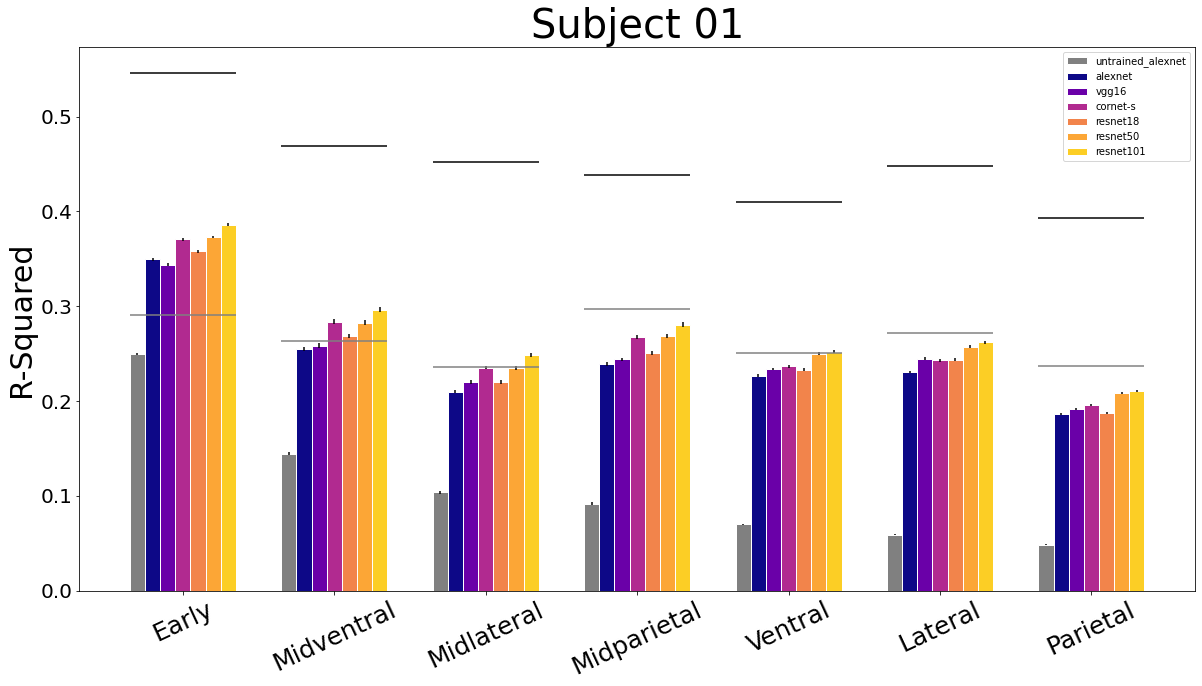

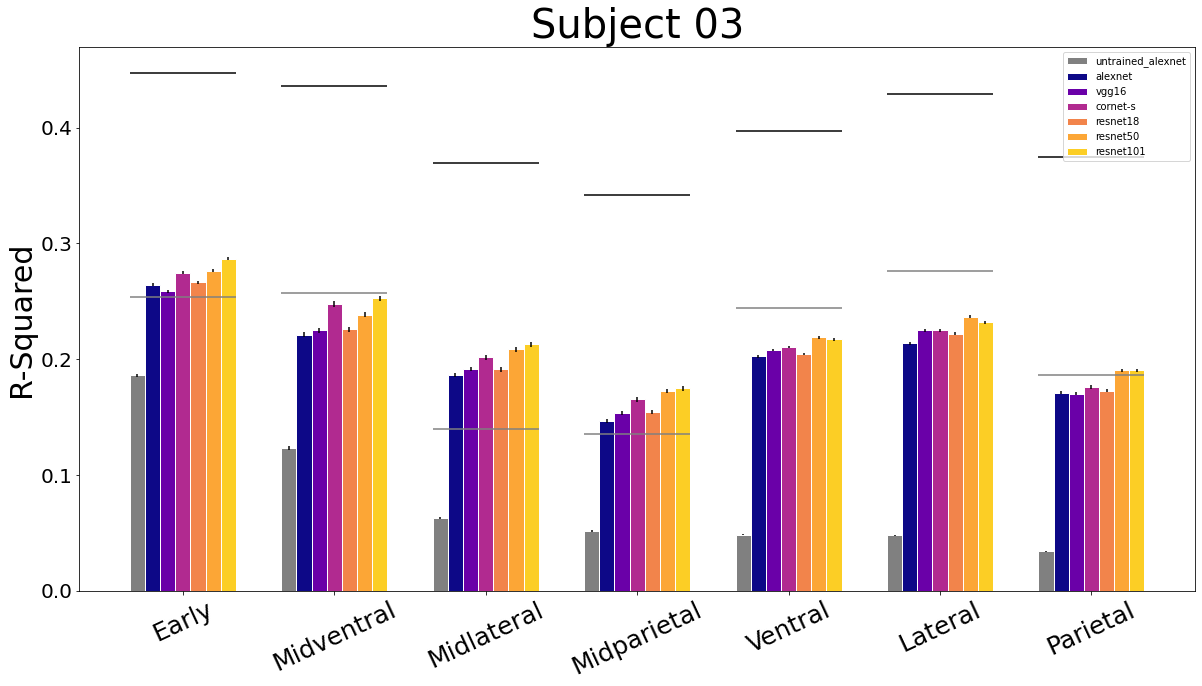

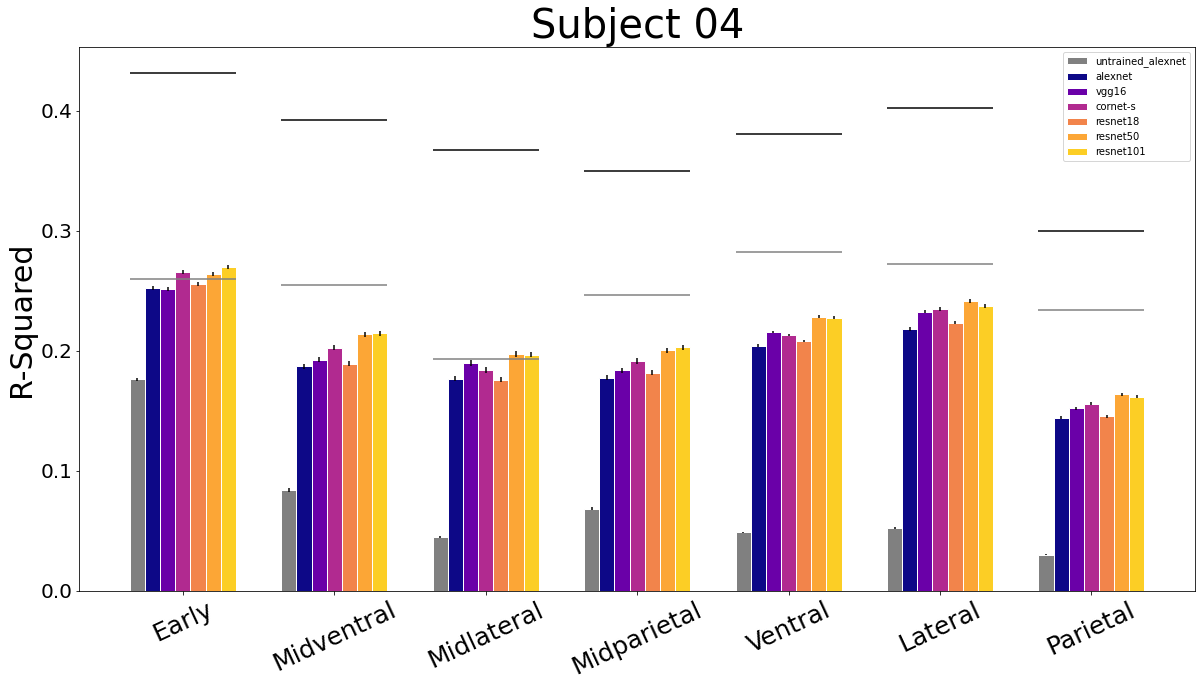

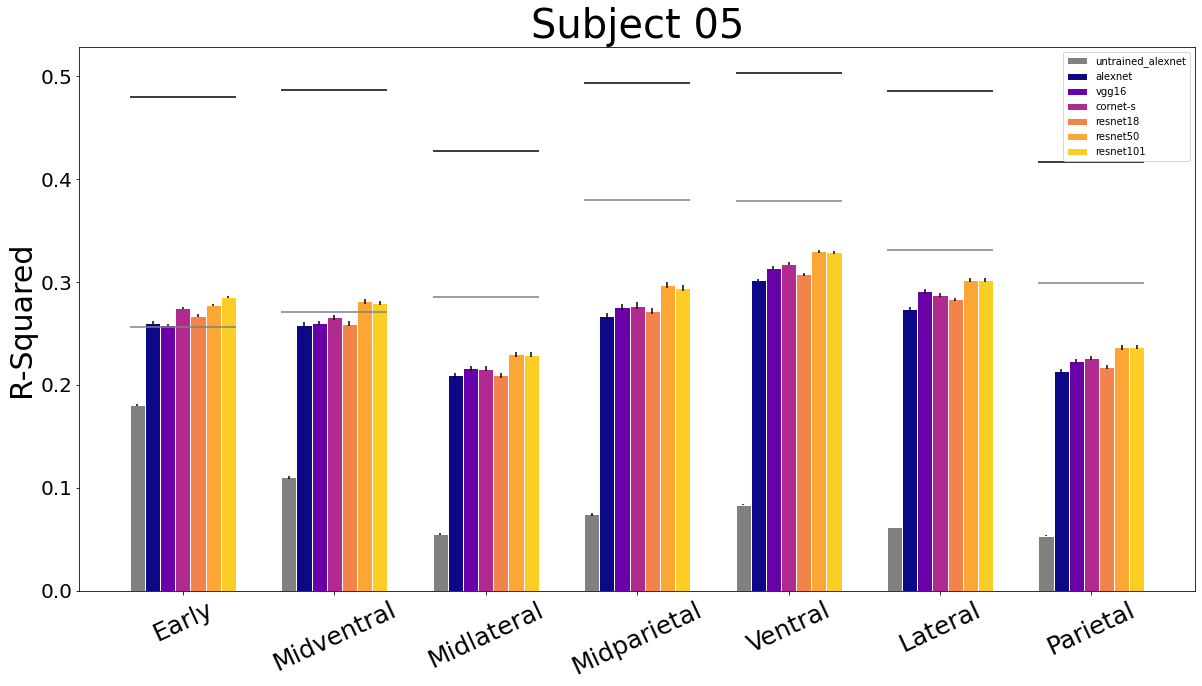

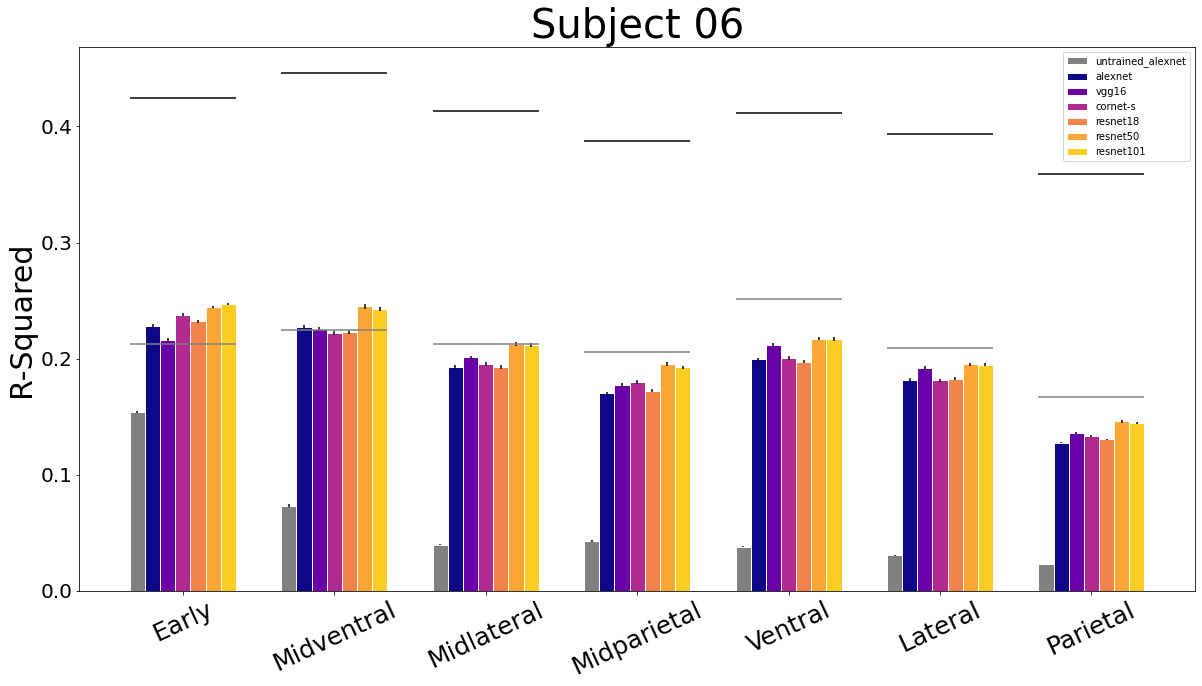

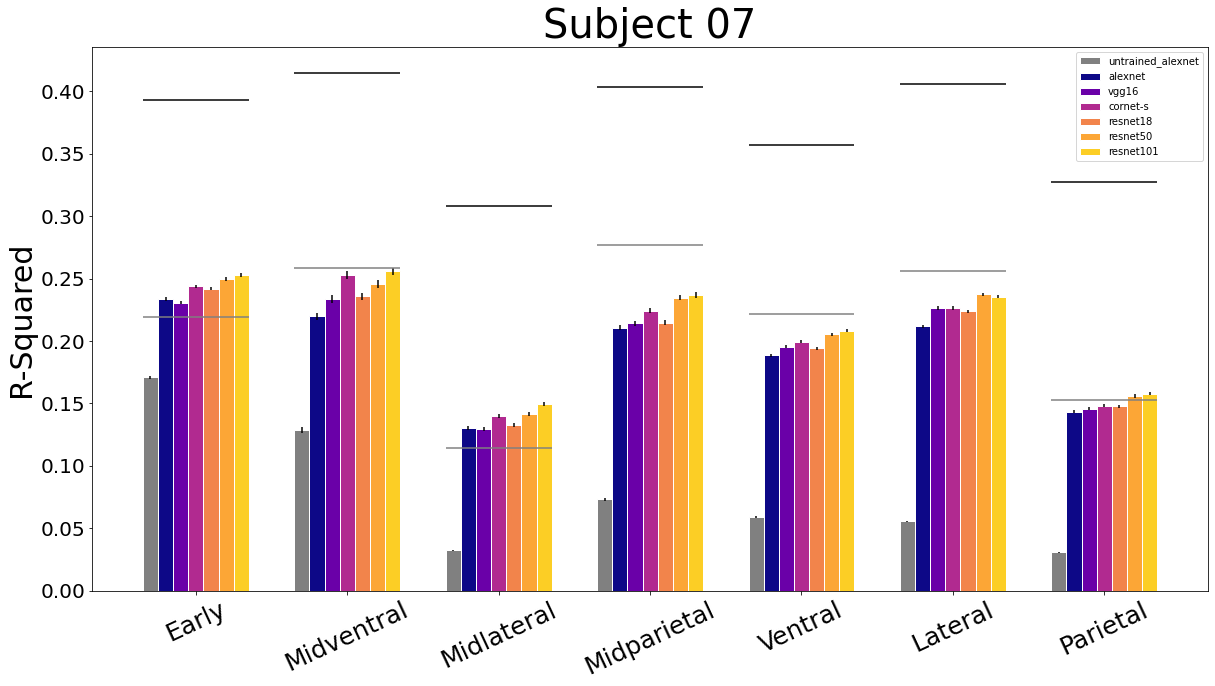

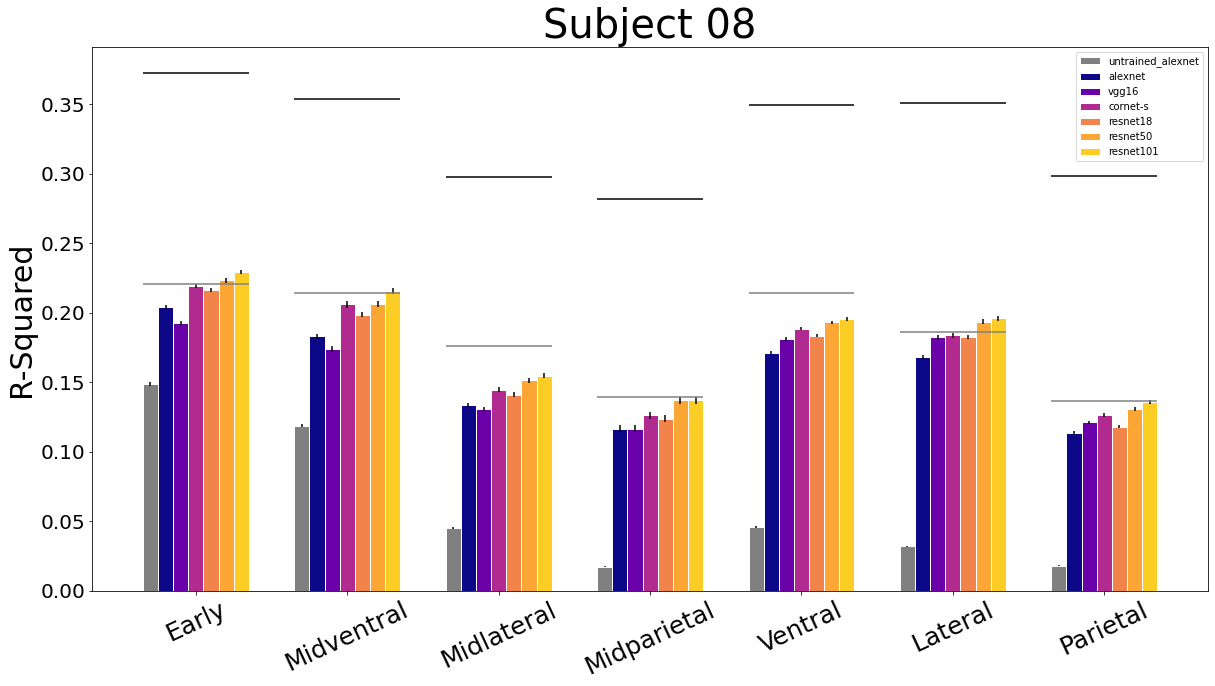

In [10]:
cmap = matplotlib.cm.get_cmap('plasma')
rgba = np.zeros((len(models), 4))
color_range = [0, 0, .2, .4, .7, .8, .9, .99]
for midx, model_name in enumerate(models):
    if model_name == "untrained_alexnet":
        rgba[midx,:] = [128/255, 128/255, 128/255, 1]
    else:
        rgba[midx,:] = cmap(color_range[midx])
    
for sidx, sid in enumerate(subjid):
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.patch.set_facecolor('white')

    subj_nc = [np.mean(all_nc[sidx][r]) for r in range(len(ROI_NAMES))]
    subj_s2s = means_s2s[sidx]
    
    # set width of bars
    barWidth = 0.1
    
    for midx, model_name in enumerate(models):
        
        data = [np.mean(all_rs[sidx][r][midx]) for r in range(len(ROI_NAMES))]
        error = [stats.sem(all_rs[sidx][r][midx]) for r in range(len(ROI_NAMES))]

        # Set position of bar on X axis
        if midx == 0:
            base = np.arange(len(data))
            r = [x - (barWidth)*(len(models)/2) for x in base]
        else:
            r = [x + barWidth for x in prev_r]

        # Make the plot
        if model_name == "alexnet_torch":
            plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = rgba[midx], label="alexnet")
        else:
            plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = rgba[midx], label=model_name)

        prev_r = r

    # iterate over range of number of rows
    for r in range(len(ROI_NAMES)):
        ax.hlines(y = subj_nc[r], xmin = r - barWidth/2 - (len(models)/2)*barWidth, xmax = r - barWidth/2 + (len(models)/2)*barWidth,
                  color = 'black')
        ax.hlines(y = subj_s2s[r], xmin = r - barWidth/2 - (len(models)/2)*barWidth, xmax = r - barWidth/2 + (len(models)/2)*barWidth,
                  color = 'gray')

    plt.xticks([r - barWidth/2 for r in range(len(data))], ROI_NAMES, rotation=25, fontsize=25);

    plt.ylabel('R-Squared',size = 30)
    plt.yticks(fontsize=20)

    title_string = "Subject "
    title_string += sid
    plt.title(title_string,size = 40)

    # Create legend & Show graphic
    plt.legend(fontsize=10)

    save_path = (RESULTS_PATH 
                + "fits/figures/subj"
                + sid
                + "_"
                + hemi
                + "_"
                + roi
                + "_PCA_fitcomp_bymodel.png")

    #fig.savefig(save_path)
    plt.show()



### Experimenting with pandas and seaborn

In [11]:
nc_mean_across_subj = np.mean(means_nc, axis=0)
nc_sem_across_subj = stats.sem(means_nc, axis=0)

s2s_mean_across_subj = np.mean(means_s2s, axis=0)
s2s_sem_across_subj = stats.sem(means_s2s, axis=0)

In [12]:
d = {
    'subject_name': np.concatenate((np.tile('subj01',len(ROI_NAMES)*len(models)), 
                                    np.tile('subj02',len(ROI_NAMES)*len(models)), 
                                    np.tile('subj03',len(ROI_NAMES)*len(models)),
                                    np.tile('subj04',len(ROI_NAMES)*len(models)),
                                    np.tile('subj05',len(ROI_NAMES)*len(models)),
                                    np.tile('subj06',len(ROI_NAMES)*len(models)),
                                    np.tile('subj07',len(ROI_NAMES)*len(models)),
                                    np.tile('subj08',len(ROI_NAMES)*len(models)))),
    'roi': np.tile(ROI_NAMES, len(subjid)*len(models)),
    'Model': np.ravel(np.tile(np.ravel([np.tile(m, len(ROI_NAMES)) for m in models]), len(subjid))),
    'r_squared': np.swapaxes(means,1,2).ravel(),
    'nc': np.ravel(np.tile(means_nc,len(models)))
    
}

In [13]:
print(len(d['subject_name']))
print(len(d['roi']))
print(len(d['Model']))
print(len(d['r_squared']))
print(len(d['nc']))

392
343
343
343
343


In [14]:
df = pd.DataFrame(d,columns=['subject_name','roi','Model', 'r_squared', 'nc'])
df  

ValueError: All arrays must be of the same length

In [ ]:
# Wanted palette details
roi_palette = ['#a6a6a6' , '#f4bdd8', '#ccdaff', '#b3ffc6',  '#DC267F' ,'#4d7fff','#006600']
color_codes_wanted = ROI_NAMES
#cdict = dict(zip(color_codes_wanted, [mcolors.to_rgba(c) for c in roi_palette]))
cdict = dict(zip(models, rgba))
#
mcolors.get_named_colors_mapping().update(cdict)
#
model_colors=np.ravel([np.tile(m, len(ROI_NAMES)) for m in models])

In [ ]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="roi", y="r_squared", hue="Model",palette='cool_r',data=df, ci=68, capsize = 0.05, ax=ax)
sns.stripplot(x="roi", y="r_squared", hue="Model",color='lightgray',data=df,dodge=True, alpha=0.5, ax=ax)

for idx, bar in enumerate(ax.patches):
    bar.set_color(model_colors[idx])
    bar.set_edgecolor("w")
    
h, l = ax.get_legend_handles_labels()
model_labels = [ "untrained", "alexnet", "vgg16", "cornet-s", "resnet18", "resnet50", "resnet101"]#, "slowfast"]
ax.legend(h[7:], model_labels)

#test = np.tile(models, 8)
#new_idx = 0
for points in ax.collections:
    points.set_color("lightgray") #test[new_idx])
    points.set_edgecolor("b")
    points.set_linewidth(.5)
#    new_idx += 1
    
# iterate over range of number of rows
xmin = .0445
xmax = .1525
for i in range(7):
    y1=nc_mean_across_subj[i]-nc_sem_across_subj[i]
    y2=nc_mean_across_subj[i]+nc_sem_across_subj[i]
    ax.hlines(y = y1, xmin = i-0.4, xmax = i+0.4,
              color = 'gray', alpha=0.5)
    ax.hlines(y = y2, xmin = i-0.4, xmax = i+0.4,
              color = 'gray', alpha=0.5)
    ax.axhspan(y1, y2, xmin = xmin, xmax = xmax, facecolor='gray', alpha=0.5)
    
    #s1=s2s_mean_across_subj[i]-s2s_sem_across_subj[i]
    #s2=s2s_mean_across_subj[i]+s2s_sem_across_subj[i]
    #ax.hlines(y = s1, xmin = i-0.4, xmax = i+0.4,
    #          color = 'gray', alpha=0.1)
    #ax.hlines(y = s2, xmin = i-0.4, xmax = i+0.4,
    #          color = 'gray', alpha=0.1)
    #ax.axhspan(s1, s2, xmin = xmin, xmax = xmax, facecolor='gray', alpha=0.1)
    xmin += .108 +.0258
    xmax += .108 +.0258
    
ax.set_xlabel('ROIs', fontsize=20)
ax.set_ylabel('R Squared', fontsize=20)
ax.tick_params(labelsize=15)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)




save_path = (RESULTS_PATH 
                + "fits/figures/groupavg_"
                + hemi
                + "_"
                + roi
                + "_PCA_fitcomp_bymodel_"
                + mapping_func
                + "_CV"
                + str(CV)
                + ".png")

fig.savefig(save_path)
